In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import random
import pandas as pd

In [3]:
# Q1
# a)
"""
An ellipse can be described by: Ax^2 + 2Bxy + Cy^2 - 2Dx - 2Ey + 1 = 0

Since there are 5 unknowns, we need 5 equations to solve for the ellipse.

For each point, pi=(xi, yi), plug into the equation to get: Ax_i^2 + 2Bx_i*y_i + Cy_i^2 - 2Dx_i - 2Ey_i + 1 = 0 

Then, we can solve the system of equations to get the A, B, C, D, E values. Then, we can construct the ellipse using the quadratic form.
"""

# b)
points = np.array([
    [2.92, -6.01],
    [3.40, -7.20],
    [4.99, -7.84],
    [5.48, -7.04],
    [4.20, -5.91]
])

A = np.zeros((5, 5))
b = -np.ones((5, 1))

for i in range(5):
    x_i = points[i][0]
    y_i = points[i][1]
    A[i] = np.array([x_i**2, 2*x_i*y_i, y_i**2, -2*x_i, -2*y_i])


# Solve for the ellipse
ellipse = scipy.linalg.solve(A, b)
print(ellipse)

[[ 0.01806282]
 [ 0.01206936]
 [ 0.03015325]
 [-0.00624961]
 [-0.15441197]]


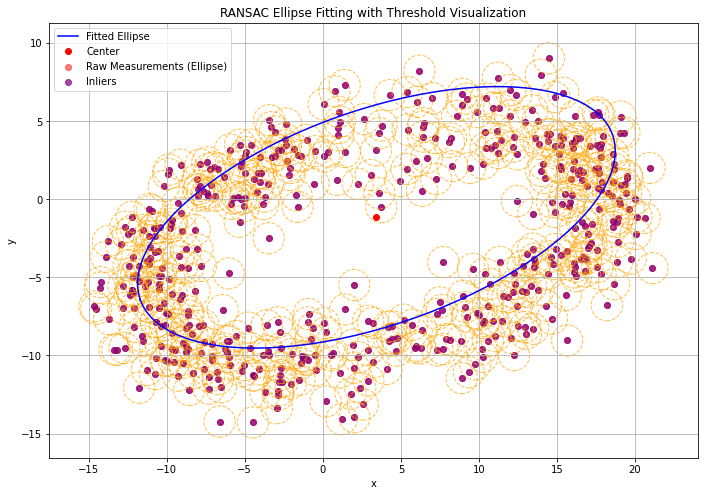

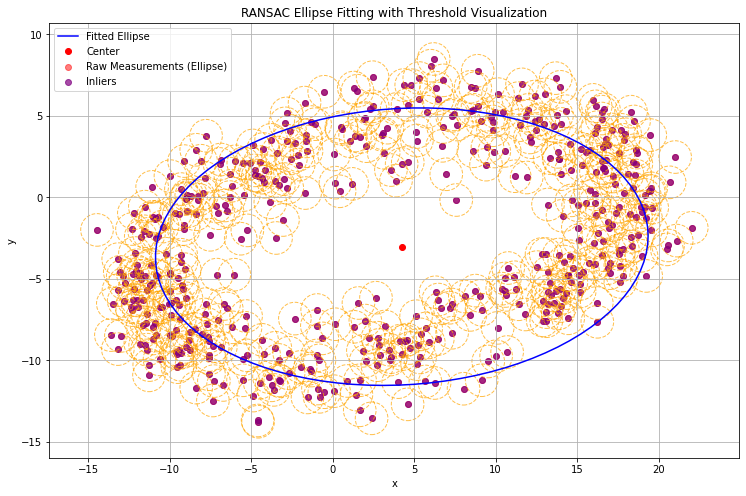

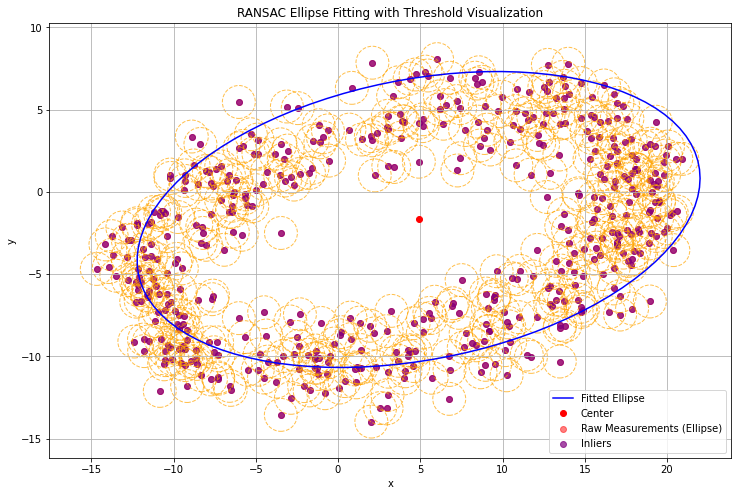

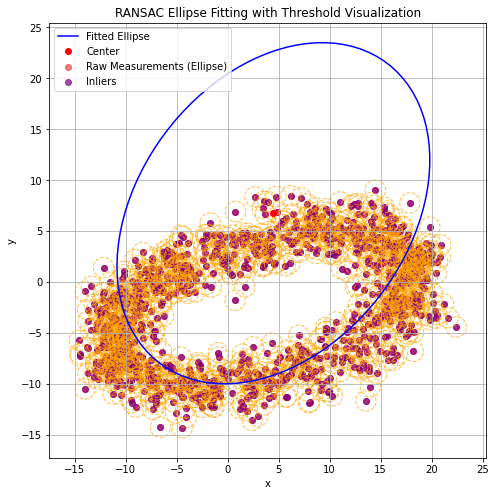

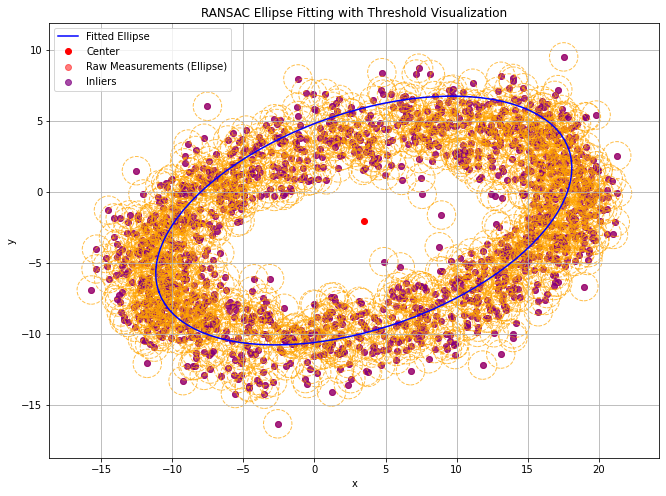

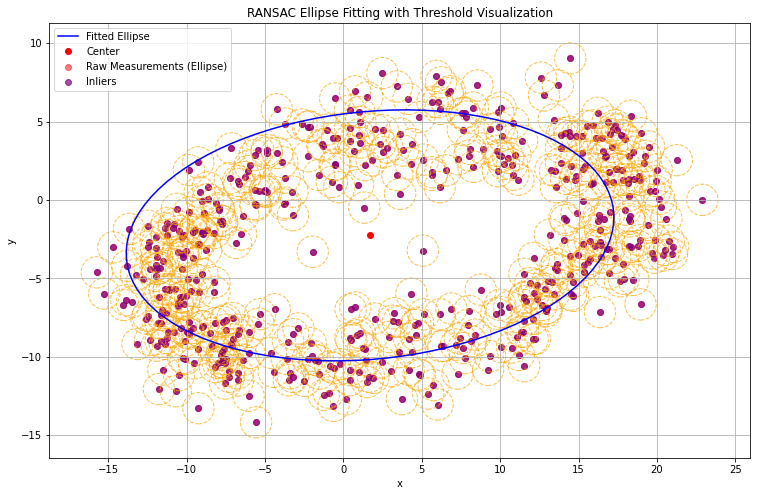

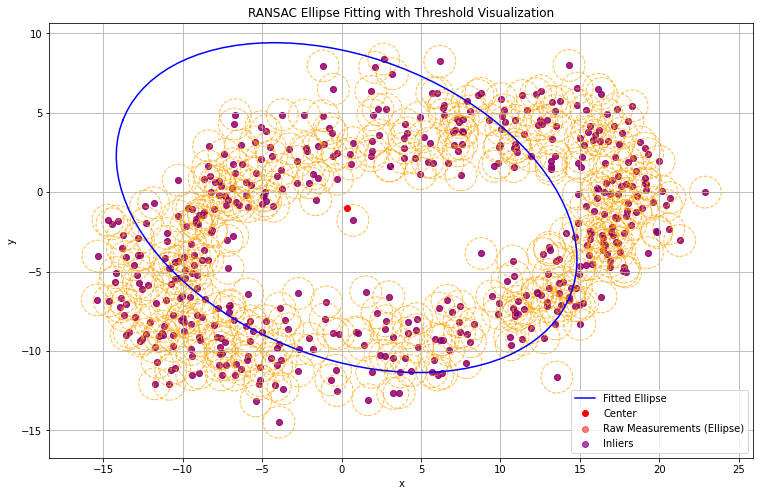

In [31]:
# Q2

def plot_ellipse(Q, b, ax):
    eigvals, eigvecs = np.linalg.eigh(Q)

    theta = np.linspace(0, 2 * np.pi, 100)
    unit_circle = np.array([np.cos(theta), np.sin(theta)])
    ellipse_param = unit_circle / np.sqrt(eigvals[:, np.newaxis])
    ellipse_points = eigvecs @ ellipse_param + b[:, np.newaxis]

    ax.plot(ellipse_points[0, :], ellipse_points[1, :], 'b-', label='Fitted Ellipse')
    ax.plot(b[0], b[1], 'ro', label='Center')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)

def visualize_data(p, ax, inliers, threshold):
    ax.scatter(p[:, 0], p[:, 1], color='red', alpha=0.5, label='Raw Measurements (Ellipse)')
    ax.scatter(inliers[:, 0], inliers[:, 1], color='purple', alpha=0.7, label='Inliers')

    for point in inliers:
        circle = plt.Circle(point, threshold, color='orange', fill=False, linestyle='--', alpha=0.7)
        ax.add_patch(circle)


def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

def fit_ellipse_subset(points):
    # Given some number of points (you have to determined this), 
    # construct an ellipse that fits through those points.

    ##### ADD your code here : #####
    A = np.zeros((5, 5))
    b = -np.ones((5, 1))

    for i in range(5):
        x_i = points[i][0]
        y_i = points[i][1]
        A[i] = np.array([x_i**2, 2*x_i*y_i, y_i**2, -2*x_i, -2*y_i])

    # Solve for the ellipse
    ellipse = scipy.linalg.solve(A, b)
    
    A_val = ellipse[0].item()
    B_val = ellipse[1].item()
    C_val = ellipse[2].item()
    D_val = ellipse[3].item()
    E_val = ellipse[4].item()
    
    # Define the Q matrix (without alpha scaling)
    prescale_Q = np.array([
        [A_val, B_val],
        [B_val, C_val]
    ])

    # Define the Qb vector (without alpha scaling)
    prescale_Qb = np.array([[D_val], [E_val]])

    # Calculate alpha
    alpha_denom = (prescale_Qb.T @ np.linalg.inv(prescale_Q) @ prescale_Qb) - 1
    alpha = 1 / alpha_denom

    # # Scale Q and b by alpha
    Q = alpha * prescale_Q
    b = np.linalg.inv(Q) @ (alpha * prescale_Qb)
    b = b.flatten()
            
    # ##### END #####
    return Q, b

def ransac_ellipse(data, num_iterations=1000, threshold=0.2):
    inliers = []
    # Given the data sets, perform RANSAC to find the best Q and b as well as the inliers
    # Hint: You should use fit_ellipse_subset 
    # Hint: in some case, the Q matrix might not be positive defintie, use is_positive_definite to check.

    ##### ADD your code here : #####
    best_inliers = np.array([])
    best_Q = None
    best_b = None

    for _ in range(num_iterations):
        # Randomly select a subset of 5 points
        subset = data[np.random.choice(data.shape[0], 5, replace=False)]

        # Fit ellipse to subset
        curr_Q, curr_b = fit_ellipse_subset(subset)

        # Check if Q is positive definite
        if not is_positive_definite(curr_Q):
            continue

        # Find inliers
        curr_inliers = []
        for point in data:
            diff = point - curr_b
            distance = np.sqrt(diff.T @ curr_Q @ diff) - 1
            if abs(distance) <= threshold:
                curr_inliers.append(point)

        # Update best fit if this model has the most inliers
        if len(curr_inliers) > len(best_inliers):
            best_inliers = curr_inliers
            best_Q = curr_Q
            best_b = curr_b

    Q = best_Q
    b = best_b.flatten()
    inliers = np.array(best_inliers)

    ##### END #####
    return Q,b,inliers


def run_ransac(all_data, N, num_iterations, threshold):
    dataset = all_data[np.random.choice(all_data.shape[0], N, replace=False), :]

    # Load the data from CSV file and select N random points
    N = 500
    num_iterations = 5000
    threshold = 1

    Q, b_est, inliers = ransac_ellipse(dataset, num_iterations=num_iterations, threshold=threshold)

    # Plot the raw measurements and fitted ellipse
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
    visualize_data(dataset, ax1, inliers, threshold=threshold)
    plot_ellipse(Q, b_est, ax1)
    ax1.set_title("RANSAC Ellipse Fitting with Threshold Visualization")

    plt.show()
    
all_data = pd.read_csv('data_x_y.csv').to_numpy()
run_ransac(all_data, 500, 5000, 1)
run_ransac(all_data, 500, 5000, 0.5)
run_ransac(all_data, 500, 5000, 5)

run_ransac(all_data, 1000, 5000, 1)
run_ransac(all_data, 1500, 5000, 1)

run_ransac(all_data, 500, 1000, 1)
run_ransac(all_data, 500, 10000, 1)

In [ ]:
# Q3
"""
3 zones: A=1 (feeding area), A=2 (rest area), A=3 (play area)

p(x_curr=1 | x_prev=1) = 0.6
p(x_curr=2 | x_prev=1) = 0.4
p(x_curr=3 | x_prev=1) = 0.0

p(x_curr=1 | x_prev=2) = 0.2
p(x_curr=2 | x_prev=2) = 0.4
p(x_curr=3 | x_prev=2) = 0.4

p(x_curr=1 | x_prev=3) = 0.2
p(x_curr=2 | x_prev=3) = 0.1
p(x_curr=3 | x_prev=3) = 0.7

a) 
Probability of 1 -> 2 -> 3 -> 3 -> 1:
p(x2=2 | x1=1) * p(x3=3 | x2=2) * p(x4=3 | x3=3) * p(x5=1 | x4=3)
= 0.4 * 0.4 * 0.7 * 0.2 = 0.0224

b)
Transition matrix:
A = [
    [0.6, 0.2, 0.2],
    [0.4, 0.4, 0.1],
    [0.0, 0.4, 0.7] 
]

c)
For current state probabilities: x = (x1, x2, x3)
Find x such that x = A*x and x1 + x2 + x3 = 1

0.6x1 + 0.2x2 + 0.2x3 = x1
0.4x1 + 0.4x2 + 0.1x3 = x2
0.0x1 + 0.4x2 + 0.7x3 = x3
x1 + x2 + x3 = 1

A = [
    [-0.4, 0.2, 0.2],
    [0.4, -0.6, 0.1],
    [0.0, 0.4, -0.3],
    [1, 1, 1]
]

b = [0, 0, 0, 1]

The stationary probabilities are the solutions to the above Ax=b

d)
p(z_curr=1 | x_curr=1) = 0.8
p(z_curr=2 | x_curr=1) = 0.1
p(z_curr=3 | x_curr=1) = 0.1

p(z_curr=1 | x_curr=2) = 0.2
p(z_curr=2 | x_curr=2) = 0.7
p(z_curr=3 | x_curr=2) = 0.1

p(z_curr=1 | x_curr=3) = 0.05
p(z_curr=2 | x_curr=3) = 0.1
p(z_curr=3 | x_curr=3) = 0.85

Sensor matrix:
C = [
    [0.8, 0.2, 0.05],
    [0.1, 0.7, 0.1],
    [0.1, 0.1, 0.85]
]

e)
prediction(x_k) = A * belief(x_k-1)
belief(x_k) = n * (C * y_k) * prediction(x_k)
"""


In [ ]:
# 3c)
# Compute one solution to the stationary probabilities

A_matrix_3c = np.array([
        [-0.4, 0.2, 0.2, 0],
        [0.4, -0.6, 0.1, 0],
        [0.0, 0.4, -0.3, 0],
        [1, 1, 1, 0]
    ])

b_vector_3c = np.array([0, 0, 0, 1])

sol_3c = scipy.linalg.lstsq(A_matrix_3c, b_vector_3c)

sol_3c_vector = np.array(sol_3c[0][:3]).reshape(-1, 1)

print(sol_3c_vector)

A_matrix_val_3c = [
    [0.6, 0.2, 0.2],
    [0.4, 0.4, 0.1],
    [0.0, 0.4, 0.7] 
]

print(A_matrix_val_3c @ sol_3c_vector)

[[0.33333333]
 [0.28571429]
 [0.38095238]]
[[0.33333333]
 [0.28571429]
 [0.38095238]]


In [13]:
# Q4

def decode_measurement(measurements):
    readings = []
    for measurement in measurements:
        readings.append(np.argmax(measurement) + 1)  # +1 for 1-based indexing
    return readings

def moodeng_behavior_update(state, A):
    # Given the current state, and the transition matrix A, 
    # randomly return the next state of Moo-Deng based on A
    ##### ADD your code here : #####
    row = A[state - 1]
    row = row / np.sum(row)
    next_state = np.random.choice([1, 2, 3], p=row)
    ##### END #####
    return next_state
def sensor_measurement(state, C):
    # Given a state, and the matrix C, 
    # randomly return the encoded measurement based on C
    # Note that : 
    # F -> np.array([1,0,0])
    # R -> np.array([0,1,0])
    # P -> np.array([0,0,1])
    ##### ADD your code here : #####
    row = C[state - 1]
    row = row / np.sum(row)
    measurement = np.random.choice([1, 2, 3], p=row)
    measurement = np.eye(3)[measurement - 1].T    
    ##### END #####
    return measurement

def sim_moodeng(initial_state=1,iteration = 20):
    # Given an initial state of Moo-Deng's whereabout and number of iteration,
    # simulate Moo-Deng's behavior and the designed state estimator
    
    belief = np.array([1/3, 1/3, 1/3])  # Initial belief for the Bayesian filter
    
    ##### ADD your code here : #####
    A = np.array([
        [0.6, 0.2, 0.2],
        [0.4, 0.4, 0.1],
        [0.0, 0.4, 0.7] 
    ])
    
    C = np.array([
        [0.8, 0.2, 0.05],
        [0.1, 0.7, 0.1],
        [0.1, 0.1, 0.85]
    ])
    ##### END #####

    states = []
    measurements = []
    estimated_states = []
    beliefs = []
    state = initial_state
    for i in range(iteration):
               
        ##### ADD your code here : #####
        next_state = moodeng_behavior_update(state, A)
        measurement = sensor_measurement(next_state, C)

        predicted_belief = A @ belief
        updated_belief = (C @ measurement) * predicted_belief
        
        # Normalize belief
        updated_belief = updated_belief / np.sum(updated_belief)
                
        estimated_state = np.argmax(updated_belief) + 1
        
        belief = updated_belief
        state = next_state

        ##### END #####
        states.append(next_state)
        measurements.append(measurement)
        beliefs.append(updated_belief)
        estimated_states.append(estimated_state)
        
    return states, measurements, estimated_states, beliefs

    
# Run the simulation

states, measurements, estimated, beliefs = sim_moodeng(initial_state=1, iteration=30)

readings = decode_measurement(measurements)

# Print results
print("True states:          ", states)
print("Sensor measurements:  ", readings)
print("Estimated states:     ", estimated)
print("Belief sequence:      ", np.array(beliefs))


True states:           [1, 1, 1, 2, 3, 2, 1, 2, 3, 3, 2, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 1, 1, 3]
Sensor measurements:   [1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 2, 3, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 1, 2, 3]
Estimated states:      [1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 2, 3, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 3, 3, 2, 2, 1, 2, 3]
Belief sequence:       [[0.8        0.09       0.11      ]
 [0.27941967 0.69022031 0.03036002]
 [0.78373632 0.12283027 0.09343341]
 [0.27420637 0.69521262 0.03058101]
 [0.05008861 0.1264257  0.82348569]
 [0.20585596 0.50084175 0.29330229]
 [0.75888375 0.10482787 0.13628839]
 [0.89028502 0.0793643  0.03035068]
 [0.24840337 0.34920747 0.40238916]
 [0.03732234 0.06963828 0.89303939]
 [0.21413044 0.46059109 0.32527847]
 [0.03618911 0.07662594 0.88718495]
 [0.0185521  0.02315504 0.95829286]
 [0.01729432 0.01876205 0.96394363]
 [0.2210873  0.4144195  0.3644932 ]
 [0.76430785 0.09627286 0.13941929]
 [0.27674702 0.68601323 0.03723975]
 [0.78288985 0.12246971